In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns 
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torch.optim import Adam

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dataset

In [ ]:
def label2index(label: str) -> int:
    label_to_index = {
        'Cuc': 0,
        'Dao': 1,
        'Lan': 2,
        'Mai': 3,
        'Tho': 4
    }
    return label_to_index.get(label, -1)

class HoaVietNam(Dataset):
    def __init__(self, root_folder):
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
        self.file_paths = [
            f for f in sorted(glob.glob(os.path.join(root_folder, "*/*")))
            if os.path.isfile(f) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label_name = os.path.basename(os.path.dirname(path))
        label = label2index(label_name)

        image = Image.open(path).convert("RGB")
        image = self.transforms(image)
        return image, label

# Model 

In [3]:
class LeNet(nn.Module):
    def __init__(self, num_classes: int):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 30 * 30, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Tinh toan cac do do 

In [4]:
def compute_scores(y_pred, y_true):
    return {
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred)
    }


# Huan luyen mo hinh

In [5]:
def train_model(epoch, model, loader, optimizer, criterion, device, train_loss):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(loader), desc=f"Epoch {epoch} - Training") as pbar:
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))
            pbar.update(1)

    epoch_loss = running_loss / len(loader)
    train_loss.append(epoch_loss)


def evaluate_model(epoch, model, loader, device, acc_list):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad(), tqdm(total=len(loader), desc=f"Epoch {epoch} - Eval   ") as pbar:
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            trues = labels.cpu().numpy()

            all_preds.extend(preds)
            all_trues.extend(trues)
            pbar.update(1)

    scores = compute_scores(all_preds, all_trues)
    acc_list.append(scores['accuracy'])
    return scores, all_preds, all_trues 


## Save Checkpoint

In [6]:
def save_checkpoint(model, optimizer, epoch, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }, path)

## Huan luyen mo hinh LeNet voi Early Stopping

Epoch 0 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 38.64it/s]


Scores: {'f1': 0.17302231237322516, 'accuracy': 0.3}


Epoch 1 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 40.18it/s]


Scores: {'f1': 0.20606060606060606, 'accuracy': 0.3}


Epoch 2 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 39.57it/s]


Scores: {'f1': 0.22816326530612244, 'accuracy': 0.32}


Epoch 3 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 36.34it/s]


Scores: {'f1': 0.2126984126984127, 'accuracy': 0.3}


Epoch 4 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 38.47it/s]


Scores: {'f1': 0.25702472293265133, 'accuracy': 0.32}


Epoch 5 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 36.60it/s]


Scores: {'f1': 0.2036271186440678, 'accuracy': 0.3}


Epoch 6 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 39.03it/s]


Scores: {'f1': 0.23633598585322727, 'accuracy': 0.32}


Epoch 7 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 39.48it/s]


Scores: {'f1': 0.27128189457601226, 'accuracy': 0.36}


Epoch 8 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 39.52it/s]


Scores: {'f1': 0.4207619047619048, 'accuracy': 0.46}


Epoch 9 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 39.46it/s]


Scores: {'f1': 0.3194321653189578, 'accuracy': 0.38}


Epoch 10 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 38.93it/s]


Scores: {'f1': 0.3404761904761905, 'accuracy': 0.38}


Epoch 11 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 38.16it/s]


Scores: {'f1': 0.4471428571428572, 'accuracy': 0.48}


Epoch 12 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 38.56it/s]


Scores: {'f1': 0.46024207676381595, 'accuracy': 0.5}


Epoch 13 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 30.82it/s]


Scores: {'f1': 0.4756628912434539, 'accuracy': 0.52}


Epoch 14 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 30.53it/s]


Scores: {'f1': 0.4933333333333333, 'accuracy': 0.54}
***********DANH GIA TREN TEST****************


Epoch Test - Eval   : 100%|██████████| 7/7 [00:00<00:00, 35.37it/s]


Danh gia tren Test: {'f1': 0.588, 'accuracy': 0.6}


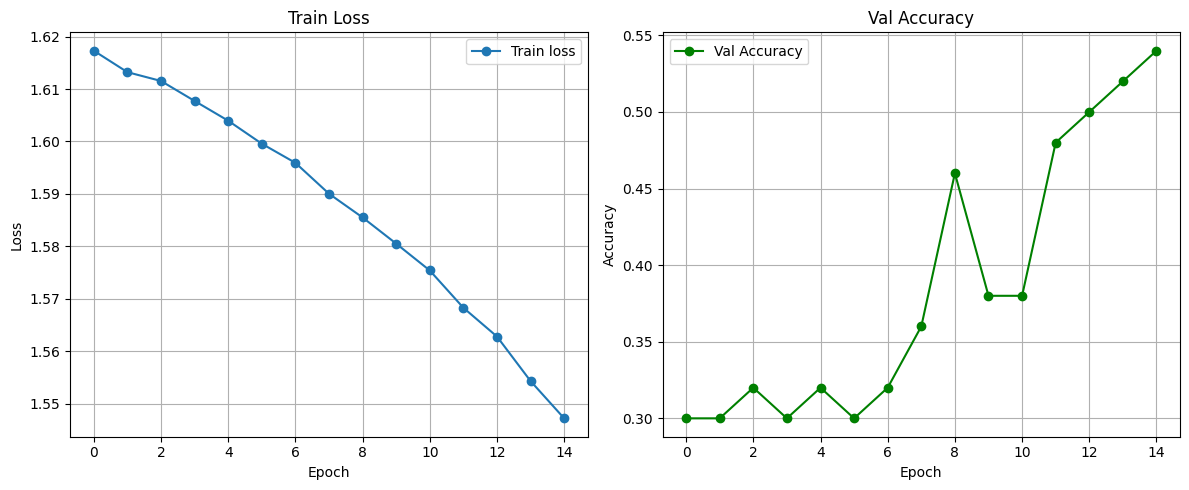

**********Confusion matrix***********


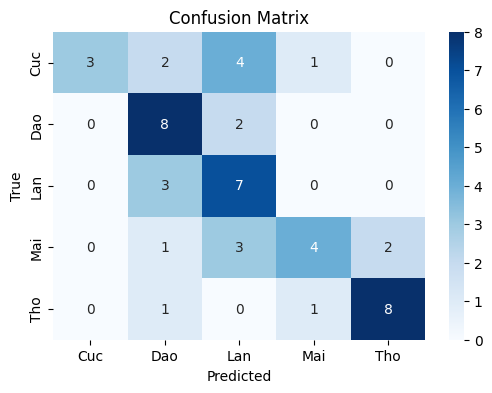

************Classfication Report*********
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.53      0.80      0.64        10
           2       0.44      0.70      0.54        10
           3       0.67      0.40      0.50        10
           4       0.80      0.80      0.80        10

    accuracy                           0.60        50
   macro avg       0.69      0.60      0.59        50
weighted avg       0.69      0.60      0.59        50



In [7]:
def main(learning_rate):
    
    train_dir = "/home/huatansang/Documents/IntroductiontoCV/HoaVietNam/train"
    test_dir = "/home/huatansang/Documents/IntroductiontoCV/HoaVietNam/test"
    checkpoint_dir = "/home/huatansang/Documents/IntroductiontoCV/lenet_checkpoint"

    train_loss = []
    train_acc = []
    test_acc = []

    full_dataset = HoaVietNam(train_dir)
    train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=1/3, random_state=42)
    train_ds = Subset(full_dataset, train_idx)
    val_ds = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)
    test_loader = DataLoader(HoaVietNam(test_dir), batch_size=8, shuffle=False, num_workers=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LeNet(num_classes=5).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_f1, patience = 0.0, 0
    max_epochs, early_stop = 15, 5
    for epoch in range(max_epochs):
        train_model(epoch, model, train_loader, optimizer, criterion, device, train_loss)
        scores, _, _ = evaluate_model(epoch, model, val_loader, device, train_acc)
        print(f"Scores: {scores}")

        if scores['f1'] > best_f1:
            best_f1 = scores['f1']
            patience = 0
            save_checkpoint(model, optimizer, epoch, os.path.join(checkpoint_dir, 'best_model.pth'))
        else:
            patience += 1
            if patience >= early_stop:
                print("Dung huan luyen do early stopping")
                break

    checkpoint = torch.load(os.path.join(checkpoint_dir, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state'])
    
    print("***********DANH GIA TREN TEST****************")
    test_scores, all_pred, all_true = evaluate_model('Test', model, test_loader, device, test_acc)
    print(f"Danh gia tren Test: {test_scores}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Val Accuracy", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Val Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print("**********Confusion matrix***********")
    cm = confusion_matrix(all_true, all_pred)

    labels = ['Cuc', 'Dao', 'Lan', 'Mai', 'Tho']

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("************Classfication Report*********")
    print(classification_report(all_true, all_pred))
if __name__ == "__main__":
    main(1e-5)


# Tang Learning Rate 

Epoch 0 - Training:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 0 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 34.36it/s]


Scores: {'f1': 0.28011122994652404, 'accuracy': 0.4}


Epoch 1 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 36.80it/s]


Scores: {'f1': 0.31039685314685317, 'accuracy': 0.4}


Epoch 2 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 37.94it/s]


Scores: {'f1': 0.7877066418662326, 'accuracy': 0.8}


Epoch 3 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 35.50it/s]


Scores: {'f1': 0.8129333333333334, 'accuracy': 0.82}


Epoch 4 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 34.80it/s]


Scores: {'f1': 0.6433864592630372, 'accuracy': 0.7}


Epoch 5 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 36.41it/s]


Scores: {'f1': 0.645132512415121, 'accuracy': 0.68}


Epoch 6 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 35.80it/s]


Scores: {'f1': 0.7942840192268109, 'accuracy': 0.8}


Epoch 7 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 31.01it/s]


Scores: {'f1': 0.7515029239766082, 'accuracy': 0.74}


Epoch 8 - Eval   : 100%|██████████| 7/7 [00:00<00:00, 35.38it/s]


Scores: {'f1': 0.7756982872200264, 'accuracy': 0.78}
Dung huan luyen do early stopping
***********DANH GIA TREN TEST****************


Epoch Test - Eval   : 100%|██████████| 7/7 [00:00<00:00, 28.47it/s]


Danh gia tren Test: {'f1': 0.6377142857142857, 'accuracy': 0.66}


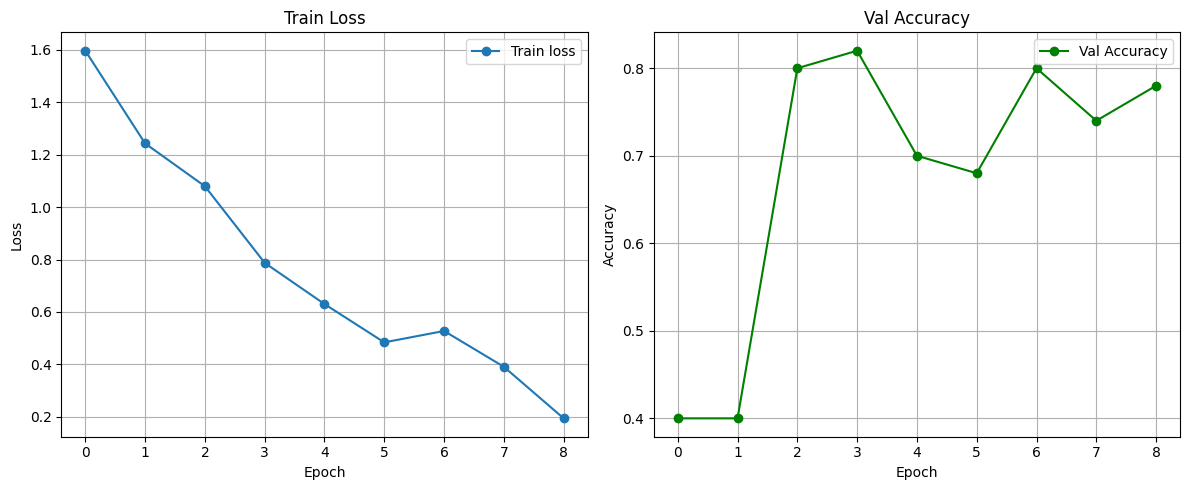

**********Confusion matrix***********


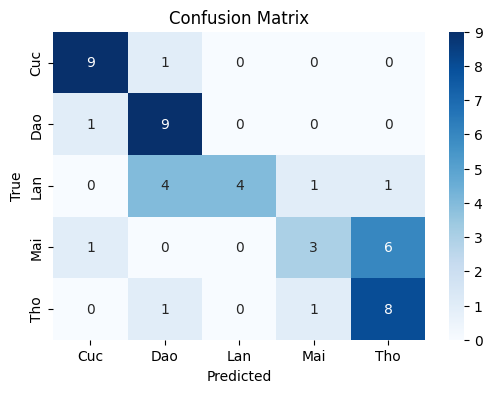

************Classfication Report*********
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.60      0.90      0.72        10
           2       1.00      0.40      0.57        10
           3       0.60      0.30      0.40        10
           4       0.53      0.80      0.64        10

    accuracy                           0.66        50
   macro avg       0.71      0.66      0.64        50
weighted avg       0.71      0.66      0.64        50



In [9]:
main(1e-3)

**=>** Ket qua cao hon khi learning rate tang